<a href="https://colab.research.google.com/github/DanielFadlon/AIforHealthcare-ObjectDetection/blob/main/proj1_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SOURCE_LIVER_PATH = './Task03_Liver'

PROJ_DIR_PATH_BRODSKY = "/content/drive/My Drive/IDC/MSc/Healthcare AI"
PROJ_DIR_PATH_FADLON = '/content/drive/MyDrive/AIforHealthcare/objectDetection'

#  ------------- Select your project directory ------------- #
PROJ_DIR = PROJ_DIR_PATH_FADLON

In [2]:
!pip install gdown
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Files
import tarfile
import shutil
import json
import nibabel as nib

# ML
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
from torchvision.ops import masks_to_boxes

# Visual
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# General
import os
from typing import Optional
from tqdm import tqdm
from google.colab import drive

torchvision.__version__, torch.__version__

('0.15.2+cu118', '2.0.1+cu118')

In [4]:
def download_data():
  !gdown --id 1nz2ouq1ghOEku-M266EjTYGBQm1DH9Rr

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PROJ_DIR_PATH = PROJ_DIR_PATH_FADLON
if os.path.exists(PROJ_DIR_PATH):
  GDRIVE_SLICES_DATA_PATH = os.path.join(PROJ_DIR_PATH, "slices_data.json")
  GDRIVE_LIVER_DATA_PATH= os.path.join(PROJ_DIR_PATH, "Task03_Liver")

os.listdir(GDRIVE_LIVER_DATA_PATH), os.path.exists(GDRIVE_SLICES_DATA_PATH)

(['._imagesTr',
  '._labelsTr',
  'labelsTr',
  '._imagesTs',
  'dataset.json',
  '._dataset.json',
  'imagesTs',
  'imagesTr'],
 True)

In [7]:
def save_data():
  download_data()
  with tarfile.open('./LiverData.tar') as tar:
    tar.extractall(path='.')

  shutil.copytree(SOURCE_LIVER_PATH, GDRIVE_LIVER_DATA_PATH)

## Load Data

In [8]:
def load_data():
  try:
    # Open the saved JSON file from drive
    with open(f'{GDRIVE_LIVER_DATA_PATH}/dataset.json', 'r') as f:
      data = json.load(f)
      return data
  except FileNotFoundError:
    save_data()
    with open(f'{SOURCE_LIVER_PATH}/dataset.json', 'r') as f:
      data = json.load(f)
      return data

data = load_data()

## Data Description And Explority Analysis

In [9]:
for key, value in data.items():
  if key != 'training' and key != 'test':
    print(f'{key}: {value}')

name: Liver
description: Liver, and cancer segmentation
reference: xxxx
licence: CC-BY-SA 4.0
release: 1.0 04/05/2018
tensorImageSize: 3D
modality: {'0': 'CT'}
labels: {'0': 'background', '1': 'liver', '2': 'cancer'}
numTraining: 131
numTest: 70


In [10]:
train_data = data.get('training')
test_data = data.get('test')

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

In [11]:
df_train.head()

image                        label
0   ./imagesTr/liver_14.nii.gz   ./labelsTr/liver_14.nii.gz
1   ./imagesTr/liver_69.nii.gz   ./labelsTr/liver_69.nii.gz
2   ./imagesTr/liver_77.nii.gz   ./labelsTr/liver_77.nii.gz
3  ./imagesTr/liver_120.nii.gz  ./labelsTr/liver_120.nii.gz
4   ./imagesTr/liver_18.nii.gz   ./labelsTr/liver_18.nii.gz

In [12]:
print(f"Train Shape: {df_train.shape}")
print(f"Test Shape: {df_test.shape}")

Train Shape: (131, 2)
Test Shape: (70, 1)


In [13]:
LABEL_BACKGROUND = 0
LABEL_LIVER = 1
LABEL_CANCER = 2

In [14]:
def get_image_data(path_in_dir, dir=GDRIVE_LIVER_DATA_PATH):
  image = nib.load(f'{dir}/{path_in_dir}')
  return image.get_fdata()


def plot_image(path, slice_idx=-1):
  img_data = get_image_data(path)

  if slice_idx == -1:  # we choose the middle slice arbitrarely
    slice_idx = img_data.shape[2] // 2
  
  slice_data = img_data[:, :, slice_idx]

  # Display the slice
  plt.imshow(slice_data.T, cmap='gray', origin='lower')
  plt.show()


def plot_bb_on_image(path, slice_idx, bb_tensor):
  fig, ax = plt.subplots(1)
  ax.imshow(slice_z, cmap='gray')

  for box in bb_tensor:
      # Create a Rectangle patch
      rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
      # Add the patch to the Axes
      ax.add_patch(rect)

  plt.show()

## Dataset Description

Input image slice:

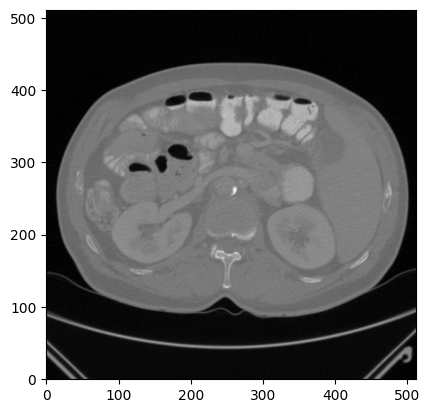

In [15]:
plot_image(df_train.image[0])

Label Image Slice

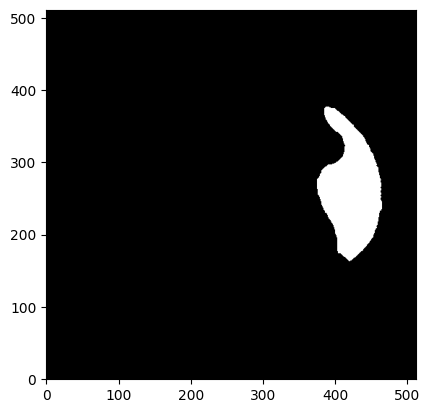

In [16]:
plot_image(df_train.label[0])

#### Visualize 3 random Slices of the same 3D image with their labels respectivly

In [17]:
# Load image 8
image8 = get_image_data(df_train.image[8])
label8 = get_image_data(df_train.label[8])

print("Number of slices : {0} / Size of each slice : {1}".format(image8.shape[2], image8.shape[:2]))

Number of slices : 856 / Size of each slice : (512, 512)


In [18]:
slice1 = image8.shape[2] // 2
slice2 = slice1 + 50
slice3 = slice1 - 50

slices15 = [slice1, slice2, slice3] 

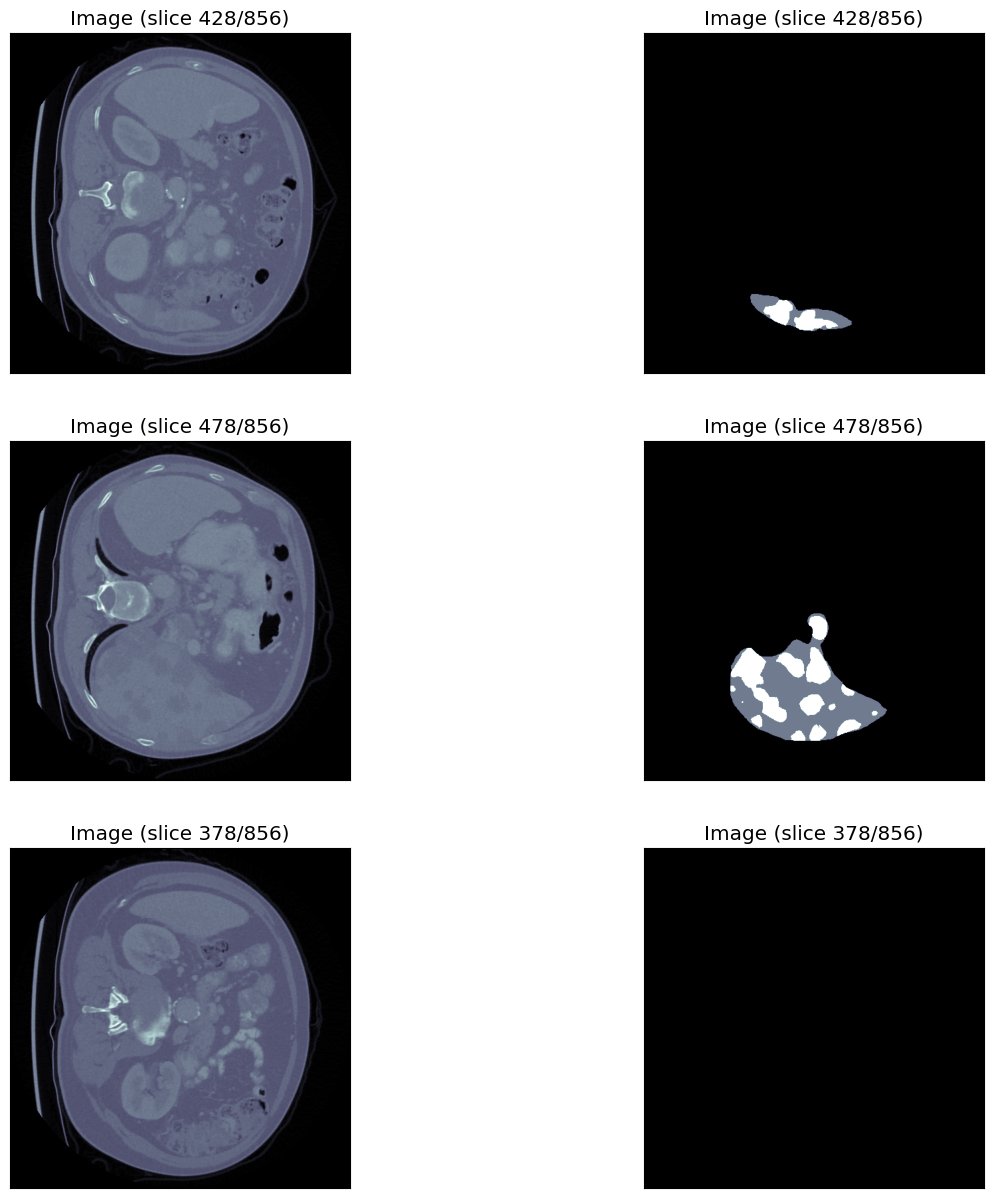

In [48]:
def show_ax_image(ax_i, image, slice_index, is_mask=False):
  title = "Mask" if is_mask else f"Image (slice {slice_index}/{image.shape[2]})"

  ax_i.imshow(image[:, :, slice_index], cmap = 'bone')
  ax_i.set_title(f"Image (slice {slice_index}/{image.shape[2]})", fontsize = 'x-large')
  ax_i.grid(False)
  ax_i.set_xticks([])
  ax_i.set_yticks([])


fig, axs = plt.subplots(3, 2, figsize = (15, 15))

for i, (ax1, ax2) in enumerate(axs):
  show_ax_image(ax1, image8, slices15[i])
  show_ax_image(ax2, label8, slices15[i])

In [20]:
def change_image_view(image):
  # change the view
  image_sagittal = np.transpose(image, [2,1,0])
  image_sagittal = np.flip(image_sagittal, axis=0)

  # change the view
  image_coronal = np.transpose(image, [2,0,1])
  image_coronal = np.flip(image_coronal, axis=0)

  fig, ax = plt.subplots(1, 3, figsize = (60, 60))
  ax[0].imshow(image[:,:,10], cmap ='bone')
  ax[0].set_title("Axial view", fontsize=60)
  ax[1].imshow(image_sagittal[:,:,260], cmap ='bone')
  ax[1].set_title("Sagittal view", fontsize=60)
  ax[2].imshow(image_coronal[:,:,200], cmap ='bone')
  ax[2].set_title("Coronal view", fontsize=60)
  plt.show()

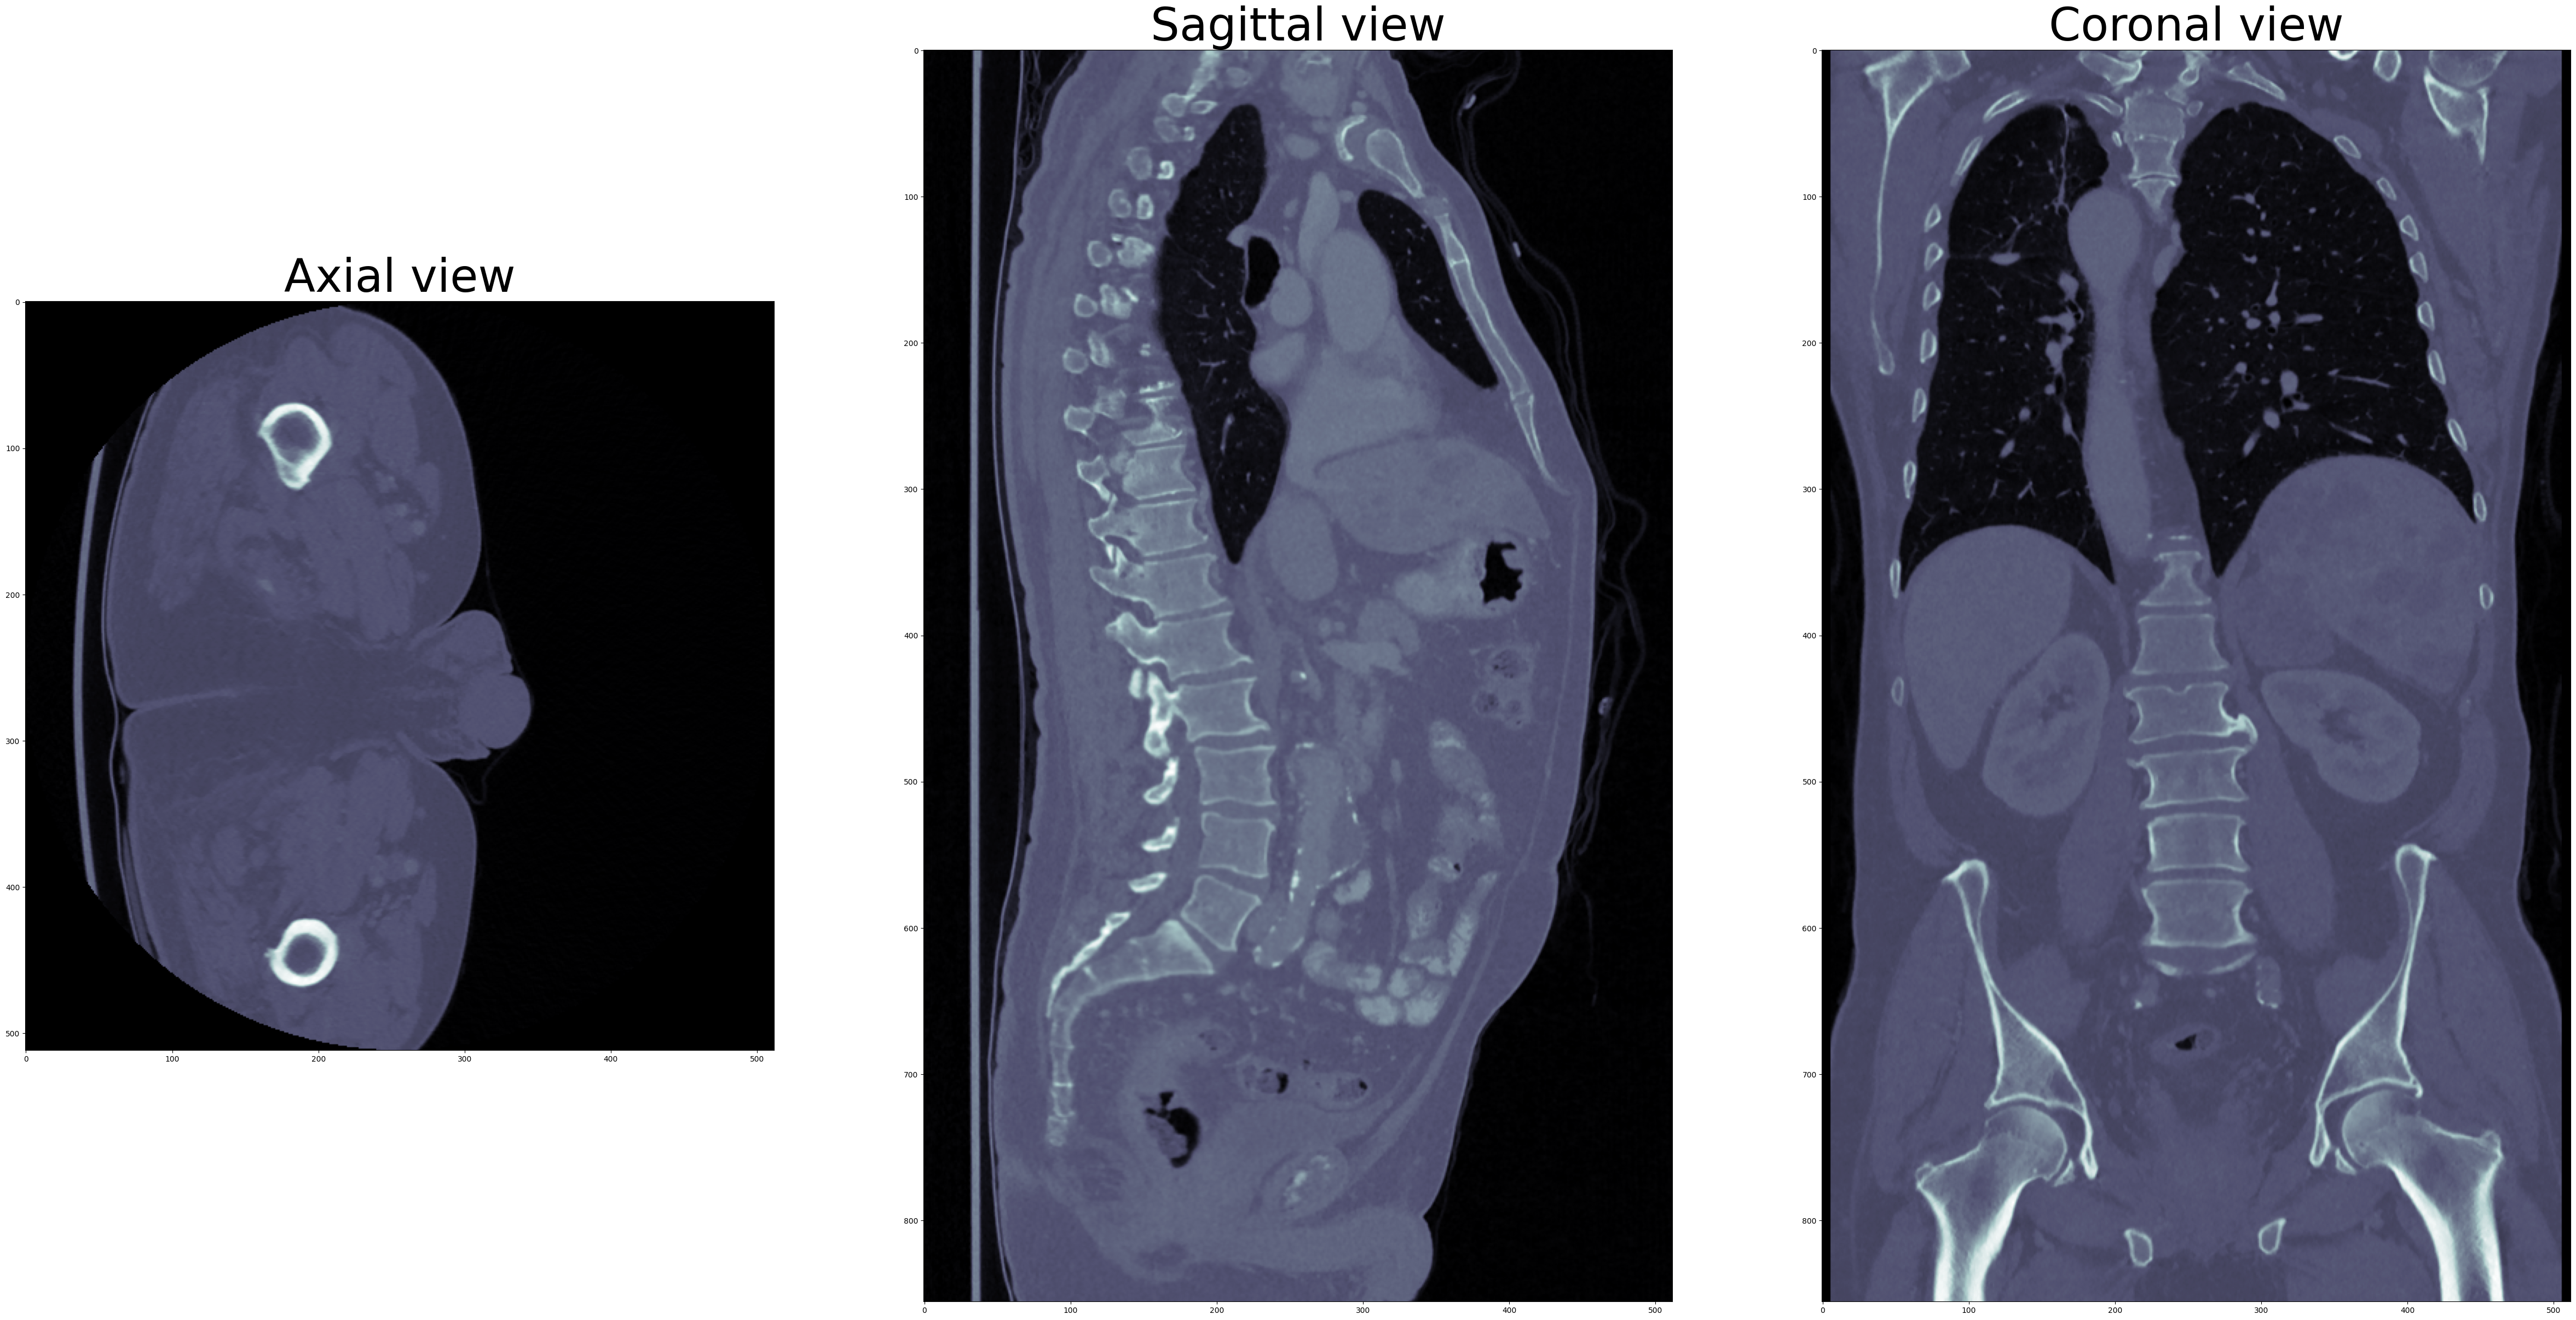

In [68]:
change_image_view(image8)

### Lables Distribution For One Liver Segmented Image

In [21]:
def get_labels_distribution(liver_segmented, return_arrays=False):
  has_liver = []
  has_cancer = []
  not_liver = []

  for slice_num in range(liver_segmented.shape[2]):
    segmented_slice = liver_segmented[:,:, slice_num]
    _, counts = np.unique(segmented_slice, return_counts = True)
    total_pixels = np.sum(counts) # Number of pixels in the image

    background_pixels = counts[LABEL_BACKGROUND]
    liver_pixels = 0
    cancer_pixels = 0

    if len(counts) == 3:
      liver_pixels += counts[LABEL_LIVER]
      cancer_pixels += counts[LABEL_CANCER]
    elif len(counts) == 2:
      liver_pixels += counts[LABEL_LIVER]

    has_liver.append(1 if liver_pixels else 0)
    has_cancer.append(1 if cancer_pixels else 0)
    not_liver.append(1 if liver_pixels == 0 else 0)

  if return_arrays:
    return not_liver, has_liver, has_cancer

  # Otherwise, return the distribution counts
  return [sum(not_liver), sum(has_liver), sum(has_cancer)]

0
No Liver  651
Liver     205
Cancer    202

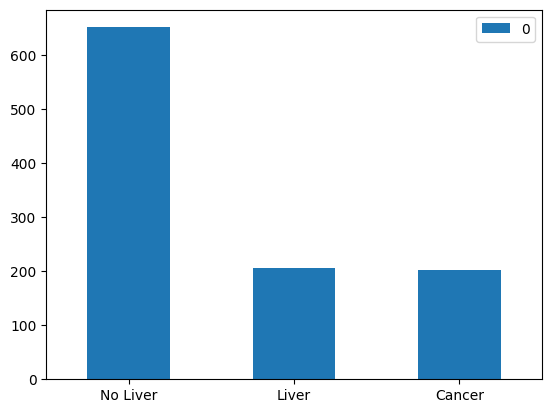

In [25]:
num_not_liver, num_has_liver, num_has_cancer = get_labels_distribution(label8)
stats = pd.DataFrame(index=['No Liver', 'Liver', 'Cancer'], data=[num_not_liver, num_has_liver, num_has_cancer])
stats.plot(kind='bar', rot=0)
stats

Text(0, 0.5, 'Class percentage (%)')

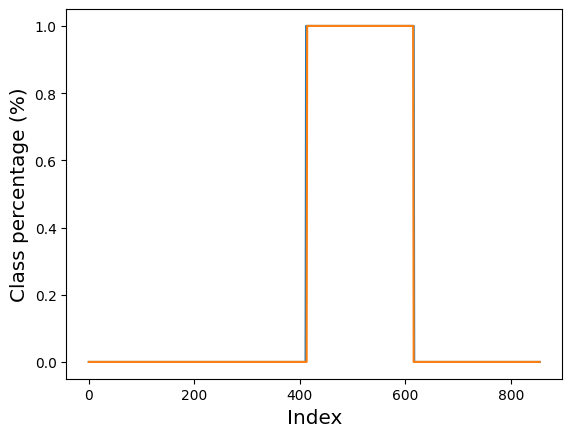

In [86]:
# visual
not_liver, has_liver, has_cancer = get_labels_distribution(label8, return_arrays=True)

plt.plot(has_liver, label="Liver")
plt.plot(has_cancer, label="Cancer")
plt.xlabel("Index", fontsize = "x-large")
plt.ylabel("Class percentage (%)", fontsize = "x-large")

Now, let's broaden our scope by studying the same process, but this time using 10 images instead of a single one.

In [89]:
total_dist = np.array([0,0,0])

for i in range(10):
  liver_segmented = get_image_data(df_train.label[i])

  dist = np.array(get_labels_distribution(liver_segmented))
  print(f"Dist for {i} --> {dist}")
  total_dist += dist

total_dist

Dist for 0 --> [449 139  16]
Dist for 1 --> [149  96  10]
Dist for 2 --> [58 36  8]
Dist for 3 --> [304 120  52]
Dist for 4 --> [656 189  44]
Dist for 5 --> [312 201  10]
Dist for 6 --> [ 77 123  18]
Dist for 7 --> [689 219 133]
Dist for 8 --> [651 205 202]
Dist for 9 --> [61 44 10]


array([3406, 1372,  503])

0
No Liver  3406
Liver     1372
Cancer     503

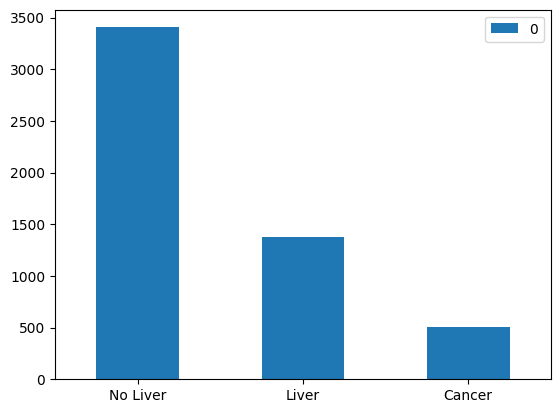

In [90]:
stats = pd.DataFrame(index=['No Liver', 'Liver', 'Cancer'], data=total_dist)
stats.plot(kind='bar', rot=0)
stats

### Converting cancer segmentation data to bounding boxes

In [45]:
def get_bounding_boxes(segmented_liver):
  cancer_mask = segmented_liver == LABEL_CANCER
  if cancer_mask.sum() ==0:
    # no cancer
    return -1 # MAYBE we need to change the return value


  labeled_mask, num_labels = label(cancer_mask)
  bounding_boxes = []
  for i in range(1, num_labels + 1):
      mask_i = (labeled_mask == i)
      mask_i = torch.from_numpy(mask_i)
      box = masks_to_boxes(mask_i.unsqueeze(dim=0))  # unsqueeze to add an extra dimension at 0th index
      bounding_boxes.append(box)

  return bounding_boxes
  

def plot_bbs_on_slice(ax, image_slice, bounding_boxes):
  ax.imshow(image_slice, cmap = 'bone')

  # Assuming bounding boxes are in (xmin, ymin, xmax, ymax) format
  for box in bounding_boxes:
      xmin, ymin, xmax, ymax = box[0]
      rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect)

Verify for image 8

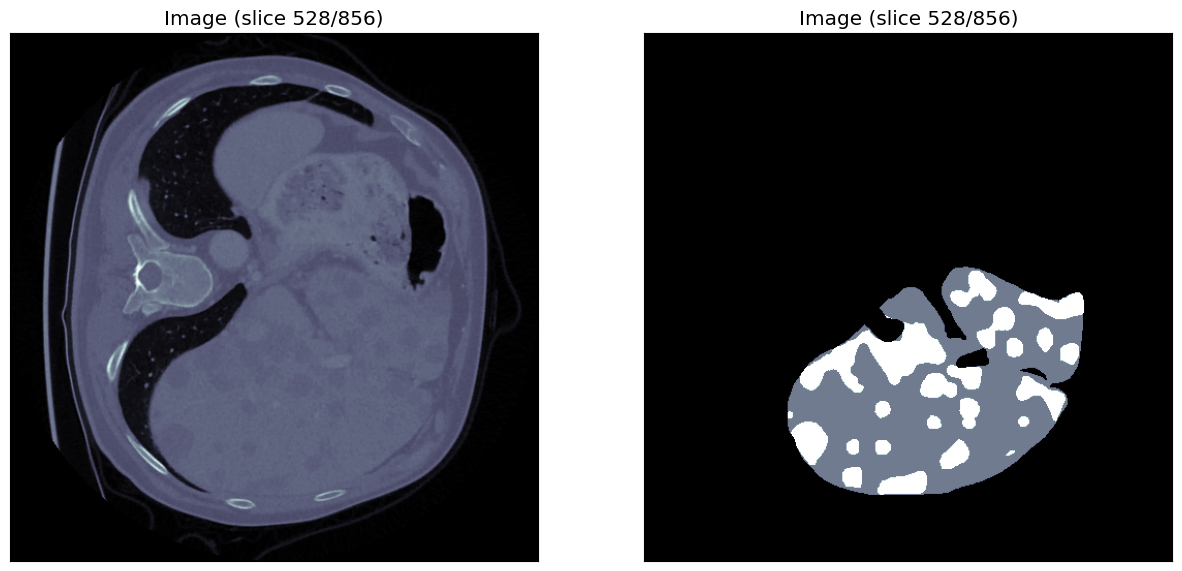

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
show_ax_image(ax1, image8, slice1)
show_ax_image(ax2, label8, slice1, is_mask=True)

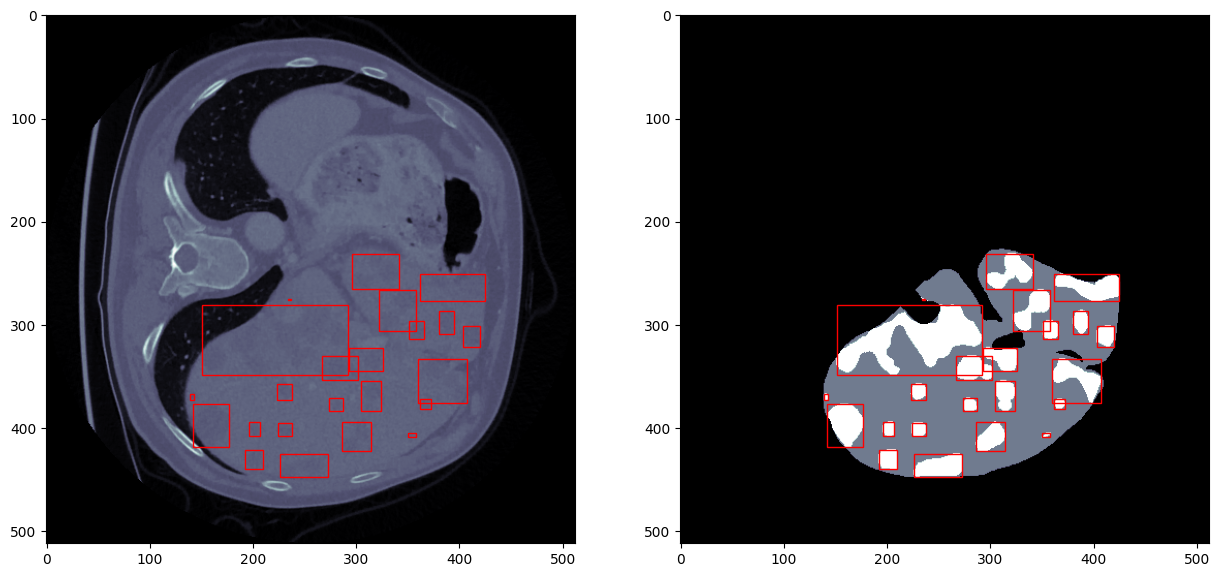

In [50]:
liver_slice8 = image8[:,:, slice1]
segmented_liver8 = label8[:,:, slice1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
bbs = get_bounding_boxes(segmented_liver8)
plot_bbs_on_slice(ax1, liver_slice8, bbs)
plot_bbs_on_slice(ax2, segmented_liver8, bbs)
plt.show()

Bounding Box for each cancer element

In [26]:
def _convert_to_tensor(mask2d):
  mask_tensor = torch.from_numpy(mask2d)
  mask_tensor = mask_tensor.to(dtype=torch.uint8)
  mask_tensor = mask_tensor.unsqueeze(dim=0) 
  return mask_tensor

def _get_2d_bb_for_slice(slice_i, color):
  if len(np.where(slice_i == 2)[0]) == 0:
    return None
  mask2d = (slice_i == color)
  mask_tensor = _convert_to_tensor(mask2d)
  box = masks_to_boxes(mask_tensor) 
  return box

def get_2d_bb_list(path, color):
  data = get_image_data(path)
  slice_bb_lst = []

  for i in range(data.shape[2]):
    boundingbox_i = _get_2d_bb_for_slice(data[:, :, i], color=2)
    # save the slice index and the bounding box in this slice.
    ### MAYBE we can replace the image with the slice or do something omre efficintly ????
    slice_bb_lst.append((i, boundingbox_i))
  
  return slice_bb_lst

In [ ]:
def get_2d_cancer_bb(sample):
  segmanted_img_path = sample['label']
  return get_2d_bb_list(segmanted_img_path, color=2)

In [ ]:
df['ith_bb'] = df.apply(get_2d_cancer_bb, axis=1)

In [ ]:
df = df.explode('ith_bb')

In [ ]:
def sep_slice_index(sample):
  return sample['ith_bb'][0]

def sep_bb(sample):
  return sample['ith_bb'][1]

In [ ]:
# separate the tuple to two columns
# possibly there is a better way =)
df['slice_index'] = df.apply(sep_slice_index, axis=1)
df['bb'] = df.apply(sep_bb, axis=1)

In [ ]:
df

image                       label       ith_bb  \
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz    (0, None)   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz    (1, None)   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz    (2, None)   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz    (3, None)   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz    (4, None)   
..                          ...                         ...          ...   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz  (239, None)   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz  (240, None)   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz  (241, None)   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz  (242, None)   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz  (243, None)   

     slice_index    bb  
0              0  None  
0              1  None  
0              2  None  
0              3  None  
0              4  None  
..           ...   ...  
130          239  None  
130          240  None  
130          241  None  
130          242  None  
130          243  None  

[58638 rows x 5 columns]

In [ ]:
df2 = df.drop('ith_bb', axis=1)

In [ ]:
df2

image                       label  slice_index    bb
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz            0  None
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz            1  None
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz            2  None
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz            3  None
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz            4  None
..                          ...                         ...          ...   ...
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          239  None
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          240  None
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          241  None
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          242  None
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          243  None

[58638 rows x 4 columns]

In [ ]:
df3 = df2.dropna()

In [ ]:
df3

image                       label  slice_index  \
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          347   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          348   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          349   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          350   
0    ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          351   
..                          ...                         ...          ...   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          162   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          166   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          167   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          174   
130  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          175   

                                                    bb  
0    [[tensor(333.), tensor(261.), tensor(341.), te...  
0    [[tensor(329.), tensor(258.), tensor(343.), te...  
0    [[tensor(327.), tensor(257.), tensor(344.), te...  
0    [[tensor(324.), tensor(258.), tensor(344.), te...  
0    [[tensor(325.), tensor(257.), tensor(344.), te...  
..                                                 ...  
130  [[tensor(290.), tensor(211.), tensor(305.), te...  
130  [[tensor(233.), tensor(317.), tensor(243.), te...  
130  [[tensor(232.), tensor(315.), tensor(242.), te...  
130  [[tensor(248.), tensor(336.), tensor(257.), te...  
130  [[tensor(250.), tensor(335.), tensor(258.), te...  

[7190 rows x 4 columns]

In [ ]:
df4 = df3.reset_index(drop=True)
df4

image                       label  slice_index  \
0     ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          347   
1     ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          348   
2     ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          349   
3     ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          350   
4     ./imagesTr/liver_14.nii.gz  ./labelsTr/liver_14.nii.gz          351   
...                          ...                         ...          ...   
7185  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          162   
7186  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          166   
7187  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          167   
7188  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          174   
7189  ./imagesTr/liver_48.nii.gz  ./labelsTr/liver_48.nii.gz          175   

                                                     bb  
0     [[tensor(333.), tensor(261.), tensor(341.), te...  
1     [[tensor(329.), tensor(258.), tensor(343.), te...  
2     [[tensor(327.), tensor(257.), tensor(344.), te...  
3     [[tensor(324.), tensor(258.), tensor(344.), te...  
4     [[tensor(325.), tensor(257.), tensor(344.), te...  
...                                                 ...  
7185  [[tensor(290.), tensor(211.), tensor(305.), te...  
7186  [[tensor(233.), tensor(317.), tensor(243.), te...  
7187  [[tensor(232.), tensor(315.), tensor(242.), te...  
7188  [[tensor(248.), tensor(336.), tensor(257.), te...  
7189  [[tensor(250.), tensor(335.), tensor(258.), te...  

[7190 rows x 4 columns]

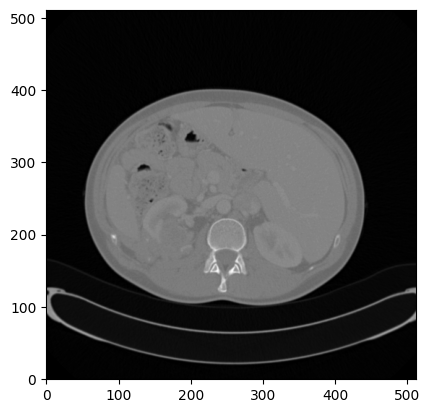

In [ ]:
plot_image('/imagesTr/liver_120.nii.gz')

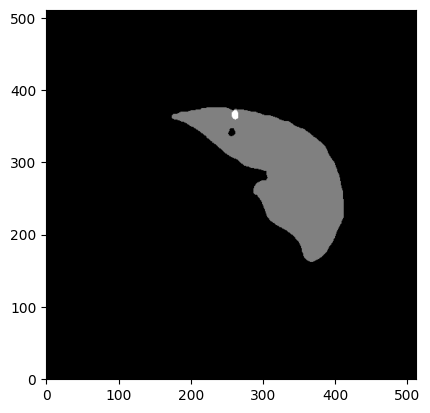

In [ ]:
plot_image('/./labelsTr/liver_120.nii.gz')

In [ ]:
fig_path = f'{gdrive_liver_dir}/./labelsTr/liver_120.nii.gz'

In [ ]:
# Load image
img = nib.load(f'{gdrive_liver_dir}/./labelsTr/liver_15.nii.gz')
# Get data as numpy array
data = img.get_fdata()
data.shape

(512, 512, 565)

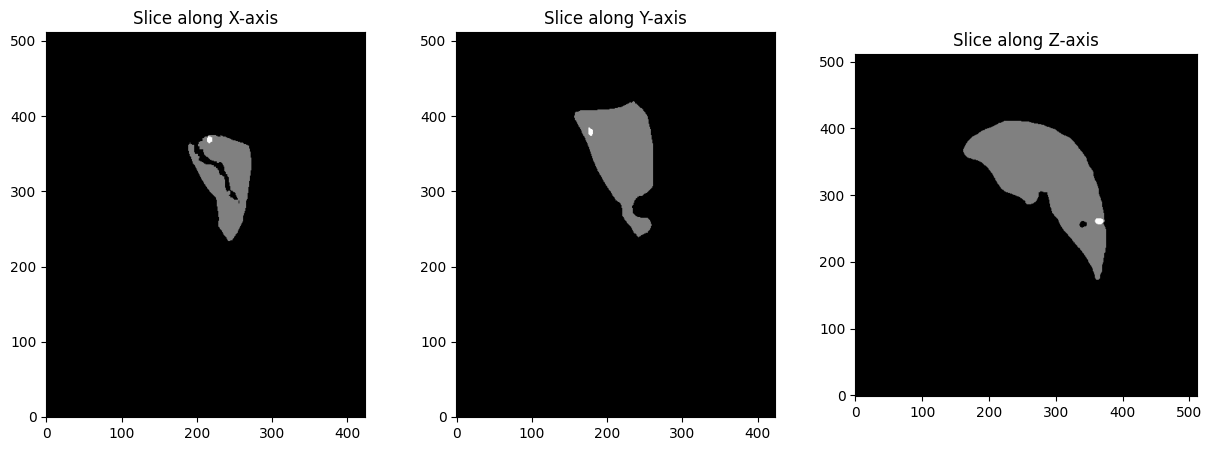

In [ ]:
# load the image
img = nib.load(fig_path)
data = img.get_fdata()

# pick slices in each dimension
slice_x = data[data.shape[0] // 2, :, :]
slice_y = data[:, data.shape[1] // 2, :]
slice_z = data[:, :, data.shape[2] // 2]

# display slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(slice_x, cmap="gray", origin="lower")
axes[0].set_title('Slice along X-axis')

axes[1].imshow(slice_y, cmap="gray", origin="lower")
axes[1].set_title('Slice along Y-axis')

axes[2].imshow(slice_z, cmap="gray", origin="lower")
axes[2].set_title('Slice along Z-axis')

plt.show()


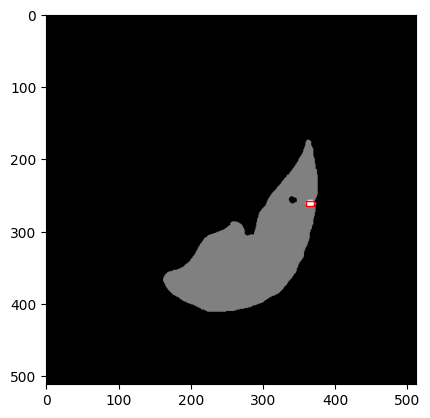

In [ ]:
# Let's assume df is your DataFrame
df1 = pd.DataFrame({
   'A': [1, 2, 3],
   'B': [10, 20, 30],
   'C': ['a', 'b', 'c']
})

# Define your function that returns a list of Series
def my_function(row):
    # Compute x as needed
    x = row['B'] - row['A']  # This is just an example, adjust as needed
    series_list = []
    for i in range(x):
        # Create a new Series for each new row
        series = pd.Series({'A': row['A'], 'D': i})
        series_list.append({'A': row['A'], 'D': i})
    return series_list

# Use apply to apply the function to each row, axis=1 means row-wise operation
df1['D'] = df1.apply(my_function, axis=1)

# Use explode to create new rows for each Series in the list in column 'D'
df1 = df1.explode('D')

# Because explode will not automatically cast the exploded column back to its original data type, 
# we need to manually do this if 'D' column should be integer.
# df1['D'] = df1['D'].astype(int)
# df1.drop()
df1


A   B  C                  D
0  1  10  a   {'A': 1, 'D': 0}
0  1  10  a   {'A': 1, 'D': 1}
0  1  10  a   {'A': 1, 'D': 2}
0  1  10  a   {'A': 1, 'D': 3}
0  1  10  a   {'A': 1, 'D': 4}
0  1  10  a   {'A': 1, 'D': 5}
0  1  10  a   {'A': 1, 'D': 6}
0  1  10  a   {'A': 1, 'D': 7}
0  1  10  a   {'A': 1, 'D': 8}
1  2  20  b   {'A': 2, 'D': 0}
1  2  20  b   {'A': 2, 'D': 1}
1  2  20  b   {'A': 2, 'D': 2}
1  2  20  b   {'A': 2, 'D': 3}
1  2  20  b   {'A': 2, 'D': 4}
1  2  20  b   {'A': 2, 'D': 5}
1  2  20  b   {'A': 2, 'D': 6}
1  2  20  b   {'A': 2, 'D': 7}
1  2  20  b   {'A': 2, 'D': 8}
1  2  20  b   {'A': 2, 'D': 9}
1  2  20  b  {'A': 2, 'D': 10}
1  2  20  b  {'A': 2, 'D': 11}
1  2  20  b  {'A': 2, 'D': 12}
1  2  20  b  {'A': 2, 'D': 13}
1  2  20  b  {'A': 2, 'D': 14}
1  2  20  b  {'A': 2, 'D': 15}
1  2  20  b  {'A': 2, 'D': 16}
1  2  20  b  {'A': 2, 'D': 17}
2  3  30  c   {'A': 3, 'D': 0}
2  3  30  c   {'A': 3, 'D': 1}
2  3  30  c   {'A': 3, 'D': 2}
2  3  30  c   {'A': 3, 'D': 3}
2  3  30  c   {'A': 3, 'D': 4}
2  3  30  c   {'A': 3, 'D': 5}
2  3  30  c   {'A': 3, 'D': 6}
2  3  30  c   {'A': 3, 'D': 7}
2  3  30  c   {'A': 3, 'D': 8}
2  3  30  c   {'A': 3, 'D': 9}
2  3  30  c  {'A': 3, 'D': 10}
2  3  30  c  {'A': 3, 'D': 11}
2  3  30  c  {'A': 3, 'D': 12}
2  3  30  c  {'A': 3, 'D': 13}
2  3  30  c  {'A': 3, 'D': 14}
2  3  30  c  {'A': 3, 'D': 15}
2  3  30  c  {'A': 3, 'D': 16}
2  3  30  c  {'A': 3, 'D': 17}
2  3  30  c  {'A': 3, 'D': 18}
2  3  30  c  {'A': 3, 'D': 19}
2  3  30  c  {'A': 3, 'D': 20}
2  3  30  c  {'A': 3, 'D': 21}
2  3  30  c  {'A': 3, 'D': 22}
2  3  30  c  {'A': 3, 'D': 23}
2  3  30  c  {'A': 3, 'D': 24}
2  3  30  c  {'A': 3, 'D': 25}
2  3  30  c  {'A': 3, 'D': 26}

In [ ]:
df1.iloc[0]['D']['A']

1